Method:
* Look at Andrea's summary for PDMPs, and more specifically the Zig Zag sampler.
* The process can be defined from ($\varphi, \lambda, Q$) where
    * $\varphi$ is the ODE dynamics - or the integral path defined by a vector field $\Phi$
    * $\lambda$ is the probability that a jumps occurs during the particle's movement
    * $Q$ is the Markov kernel used for the jump


For the reverse process, we essentially just need to compute, for all $i$:
$$ \bar \lambda_i = \lambda_i \dfrac{p_t(x_t, R_i v_t)}{p_t(x_t, v_t)} $$
Notations:
$$ s_{\theta}(x, R v, t) = \begin{pmatrix} s_{\theta}(x, R_1 v, t)_1 \\ \cdots \\ s_{\theta}(x, R_d v, t)_d \end{pmatrix}$$

We can either fit the model to

* $\bar \lambda$, and obtain the following loss:
    $$ \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - \lambda(x, v) s_{\theta}(x, R v, t)$$
* $\dfrac{p_t(x_t, R v_t)}{p_t(x_t, v_t)}$ and obtain the following loss:
    $$ \mathbb{E}_{t, x, v} \|  s_{\theta}(x, v, t) - \dfrac{p_t(x_t, R v_t)}{p_t(x_t, v_t)}\|^2 =  \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t)$$



make $s_{\theta}$ invariant to $Rv$.

ZigZag:
* $\Phi(x, v)$ = v
* $\lambda(x, v)_i = (v_i (\partial \psi(x))_i)_+$, with $\pi \propto \exp(-\psi(x))$ the target distribution. For Gaussian distribution:
$$\lambda(x, v)_i = (v_i x_i)_+ $$
* Q reverses speed.

Model:
* Model takes $(X_t, V_t)$ as input (4d)
* Outputs $\bar \lambda_i$ for each i
* Current limitations: if the dimension is $d$, we need $d+1$ forward pass, because:
$$ \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t) = \mathbb{E}_{t, x, v} \sum_{i=1}^d \frac12 s_{\theta}(x, v, t)_i^2 - s_{\theta}(x, R_i v, t)_i$$ 

Proposal for loss function:
* bla bla

TODO:
* Change the network so that it receives $R$ as an argument, and is made invariant on speed:
    $$ s_{\theta}(x, v, R) : \quad  s_{\theta}(x, Rv, R) = s_{\theta}(x, v, R)$$ 
* Take the component $i$ as an input. Idea of copula? Take a single dimension as input too? outputs a single value.
* Run the experiment on $\mathcal{N}(\mu, \sigma^2 I_2)$.
* Run the experiment on known score functions (not necessarily density ratios) just to verify that the code is working as expected. For instance do that on a simple mixture of Gaussian.
* Change the loss so that we work on the following:
    $$ \| s_{\theta}(x_t, v_t)  - \log( \dfrac{p_t(x_t, R V_t)}{p_t(x_t, V_t)} )\|_1$$
    or maybe KL loss?

# PDMP

## Setup

* Model takes $(X_t, V_t)$ as input (4 in 2d). Outputs $\lambda_i$ for each i (2 in 2d)
* Some of the code is relying on dictionnaries to define constituting parameters

In [115]:
import numpy as np
import torch
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

%matplotlib inline

p_model_2d = {
    'act' : 'silu',
    'skip_connection' : True,
    'group_norm' : True,
    'dropout_rate' : .0,
    'nblocks' : 4,
    'nunits' : 64,
    'use_a_t' : False,
    'no_a': True,
    'a_pos_emb': False, # cannot have no_a and a_pos_emb
    'a_emb_size': 32,
    'time_emb_type' : 'learnable',#'learnable',# 'one_dimensional_input',
    'time_emb_size' : 8, 
    'compute_gamma': False,
}

p_data_2d = {
    'nfeatures' : 2, # if data_type is 2d, will just project on first dimension
    'nsamples' : 4*8*1024,
    #'bs': ..., may need to add
    'dataset' : 'gmm_2',
    'std' : 0.1, # 0.5, 0.05,
    'n_mixture' : 2, # must be square. set to None if not a grid mixture
    'normalize' : True,
    #'weights': np.array([1/2]*2),
    'weights': None,#[.01, .1, .3, 
               # .2, .02, .15,
               # .02, .15, .05],# None, #np.array([.05, .95]),
    'theta': 1.,
    'alpha': 2.,
    #'isotropic': True
}

device = 'mps'

* Prepare all our objects

In [129]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import initial_code.pdmp as pdmp
import Data as Data
import Generate as Gen
from Model import LevyDiffusionModel
import torch.optim as optim
import torch.nn as nn
import Generate as Gen
import matplotlib.pyplot as plt

# original data, get dataloader
gmm_2 = Data.Generator(**p_data_2d)#('gmm_2', n_samples = 32000, theta=1, std = 0.1)
GMM2 = gmm_2.generate()
GMM2 = GMM2.unsqueeze(1) # add channel
dataset = TensorDataset(GMM2)#, torch.tensor([0.]).repeat(GMM2.shape[0]))
data = DataLoader(dataset, 
                batch_size=p_data_2d['nsamples'] // 8, 
                shuffle=True, 
                num_workers=1)

# model
model = LevyDiffusionModel({'data': {'nfeatures': p_data_2d['nfeatures']}, 'model':p_model_2d, 'device': 'cpu'}).to(device)

# optimizer
optimizer = optim.AdamW(model.parameters(), 
                        lr=1e-3, 
                        betas=(0.9, 0.99)) # beta_2 0.95 instead of 0.999

# PDMP class
pdmp = pdmp.PDMP(total_time = 8)

# Manager for data generation
gen_model = Gen.GenerationManager(model, pdmp, data)

0


## Look at the noised data

In [204]:
# clone data, since it will be modified by forward process
data_clone = GMM2.clone()
# orint its shape
print(data_clone.shape)
# get a unit time horizon
time_horizons = torch.ones(data_clone.shape) 
for i in range(int(pdmp.T)):
    t = time_horizons.clone()
    pdmp.forward(data_clone, t)
#* pdmp.T
# forward process for pmdp.T time units
#pdmp.forward(data_clone, time_horizons)

torch.Size([32768, 1, 2])


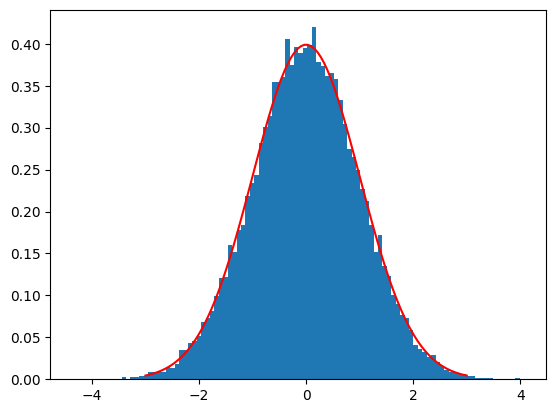

In [207]:
# look at histogram of one component at the last timestep

pos = data_clone.squeeze(1) # remove channel dimension
import scipy.stats as stats
X = np.linspace(-3, 3, 100)
Y = stats.norm.pdf(X, 0, 1)
plt.plot(X, Y, color='red')
plt.hist(pos[:, 0], bins='auto', density=True)
plt.show()

## Train the model

In [3]:
# can use this to load a model and optimizer

MODEL_PATH = 'models/first_model.pt'

chpt = torch.load(MODEL_PATH)
model.load_state_dict(chpt['model'])
optimizer.load_state_dict(chpt['optimizer'])

In [221]:
# actually training the model

from tqdm import tqdm
import torch.nn as nn

# potential gradient clipping
grad_clip = None

# training
model.train()
for i in tqdm(range(100)):
    epoch_loss = steps = 0
    for i, (Xbatch,) in enumerate(data):
        # training loss

        # generate random speed
        Vbatch = torch.tensor([-1., 1.])[torch.randint(0, 2, (2*Xbatch.shape[0],))]
        Vbatch = Vbatch.reshape(Xbatch.shape[0], 1, 2)

        # generate random time horizons
        time_horizons = pdmp.T * (torch.rand(Xbatch.shape[0])**2)

        # must be of the same shape as Xbatch for the pdmp forward process, since it will be applied component wise
        t = time_horizons.clone().detach().unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 2)
        
        # clone our initial data, since it will be modified by forward process
        x = Xbatch.clone()
        v = Vbatch.clone()
        
        # apply the forward process
        pdmp.forward(Xbatch, t, Vbatch)
        
        # check that the data has been modified
        assert ((x != Xbatch).any()) and ((v != Vbatch).any())
        # check that the time horizon has been reached for all data
        assert not (t != 0.).any()
        
        # send to device
        Xbatch = Xbatch.to(device)
        Vbatch = Vbatch.to(device)
        time_horizons = time_horizons.to(device)
        
        # tensor to give as input to the model. It is the concatenation of the position and the speed.
        X_V_t = torch.concat((Xbatch, Vbatch), dim = -1)
        #print(time_horizons[0], X_V_t[0])
        #print(X_V_t.mean(dim = 0), X_V_t.std(dim = 0))

        # run the model
        output = model(X_V_t, time_horizons)

        # invert time on component 1 and 2
        X_V_inv_t_1 = X_V_t.detach().clone() # clone to avoid modifying the original tensor, detach to avoid computing gradients on original tensor
        X_V_inv_t_2 = X_V_t.detach().clone()
        X_V_inv_t_1[:, :, 2] *= -1 # reverse speed on i = 1
        X_V_inv_t_2[:, :, 3] *= -1 # reverse speed on i = 2

        # run the model on each inverted speed component
        output_inv_1 = model(X_V_inv_t_1, time_horizons)
        output_inv_2 = model(X_V_inv_t_2, time_horizons)
        
        # compute the loss
        #speed_idx_0 = X_V_t[:, :, 2] + 1 //2 # 0 if speed_0 is -1, 1 if speed_0 is 1
        #speed_idx_1 = X_V_t[:, :, 3] + 1 //2 # 0 if speed_1 is -1, 1 if speed_1 is 1
        #loss = 0.5*output[:, :, 0]**2 - (1 / output[:,:,0])
        #loss += 0.5*output[:, :, 1]**2 - (1 / output[:,:,1])
        #loss = loss.mean()
        #normalize_mean = output.mean()
        #loss += (torch.log(normalize_mean))**2
        #loss  = (1 / (1 + output.mean()) - 1 / 2)**2
        #loss += - torch.log(output_inv_1).mean() - torch.log(output_inv_2).mean()
        if i % 10 != 0:
            loss = 0.5*output[:, :, 0]**2 - (output_inv_1[:,:,0])
            loss += 0.5*output[:, :, 1]**2 - (output_inv_2[:,:,1])
            loss = loss.mean()
        #loss = 0.5*output[:, :, 0]**2 - (output[:,:,2 + 0])
        #loss += 0.5*output[:, :, 1]**2 - (output[:,:,2 + 1])
        else:
            loss = .5*((1 / output[:,:,0]).mean() - 1)**2
            loss += .5*((1 / output[:,:,1]).mean() - 1)**2
            loss += .5*((output_inv_1[:,:,0]).mean() - 1)**2
            loss += .5*((output_inv_2[:,:,1]).mean() - 1)**2
            loss += .5*((output[:, :, 0] * output_inv_1[:,:,0] - 1).mean())**2
            loss += .5*((output[:, :, 1] * output_inv_2[:,:,1] - 1).mean())**2
            loss = loss.mean()
        #loss += (output.mean() - 1)**2
        #loss += (output_inv_1.mean() - 1)**2
        #loss += (output_inv_2.mean() - 1)**2
        #loss += (output[:, :, 0] * output_inv_1[:,:,0] - 1).mean()
        #loss += (output[:, :, 1] * output_inv_2[:,:,1] - 1).mean()
        # and finally gradient descent
        optimizer.zero_grad()
        loss.backward()
        if grad_clip is not None:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        # add to epoch loss
        epoch_loss += loss.item()
        steps+= 1
    # compute epoch loss
    epoch_loss = epoch_loss / steps
    print('epoch_loss :{}'.format(epoch_loss))

  1%|█▎                                                                                                                               | 1/100 [00:02<03:22,  2.04s/it]

epoch_loss :-4.3830302357673645


  2%|██▌                                                                                                                              | 2/100 [00:04<03:24,  2.09s/it]

epoch_loss :-4.503470718860626


  3%|███▊                                                                                                                             | 3/100 [00:06<03:26,  2.13s/it]

epoch_loss :-4.2738611698150635


  4%|█████▏                                                                                                                           | 4/100 [00:08<03:27,  2.17s/it]

epoch_loss :-4.833503007888794


  5%|██████▍                                                                                                                          | 5/100 [00:10<03:26,  2.17s/it]

epoch_loss :-4.302047371864319


  6%|███████▋                                                                                                                         | 6/100 [00:12<03:24,  2.18s/it]

epoch_loss :-4.5754037499427795


  7%|█████████                                                                                                                        | 7/100 [00:14<03:16,  2.11s/it]

epoch_loss :-4.375853180885315


  8%|██████████▎                                                                                                                      | 8/100 [00:17<03:16,  2.13s/it]

epoch_loss :-4.331538021564484


  9%|███████████▌                                                                                                                     | 9/100 [00:19<03:17,  2.17s/it]

epoch_loss :-4.707713305950165


 10%|████████████▊                                                                                                                   | 10/100 [00:21<03:14,  2.16s/it]

epoch_loss :-4.654687225818634


 11%|██████████████                                                                                                                  | 11/100 [00:23<03:10,  2.14s/it]

epoch_loss :-4.850298583507538


 12%|███████████████▎                                                                                                                | 12/100 [00:25<03:07,  2.13s/it]

epoch_loss :-3.8877599239349365


 13%|████████████████▋                                                                                                               | 13/100 [00:28<03:13,  2.22s/it]

epoch_loss :-3.9471132159233093


 14%|█████████████████▉                                                                                                              | 14/100 [00:30<03:18,  2.31s/it]

epoch_loss :-4.546732008457184


 15%|███████████████████▏                                                                                                            | 15/100 [00:33<03:18,  2.34s/it]

epoch_loss :-4.277023017406464


 16%|████████████████████▍                                                                                                           | 16/100 [00:35<03:10,  2.27s/it]

epoch_loss :-4.6476970911026


 17%|█████████████████████▊                                                                                                          | 17/100 [00:37<03:11,  2.31s/it]

epoch_loss :-4.579989433288574


 18%|███████████████████████                                                                                                         | 18/100 [00:39<03:08,  2.30s/it]

epoch_loss :-4.491903901100159


 19%|████████████████████████▎                                                                                                       | 19/100 [00:41<03:03,  2.26s/it]

epoch_loss :-4.837857723236084


 20%|█████████████████████████▌                                                                                                      | 20/100 [00:44<02:54,  2.19s/it]

epoch_loss :-4.640604674816132


 21%|██████████████████████████▉                                                                                                     | 21/100 [00:46<02:48,  2.13s/it]

epoch_loss :-4.4956143498420715


 22%|████████████████████████████▏                                                                                                   | 22/100 [00:48<02:52,  2.21s/it]

epoch_loss :-4.296931624412537


 23%|█████████████████████████████▍                                                                                                  | 23/100 [00:50<02:47,  2.18s/it]

epoch_loss :-4.152976036071777


 24%|██████████████████████████████▋                                                                                                 | 24/100 [00:52<02:43,  2.15s/it]

epoch_loss :-4.353371679782867


 25%|████████████████████████████████                                                                                                | 25/100 [00:54<02:39,  2.13s/it]

epoch_loss :-4.459840655326843


 26%|█████████████████████████████████▎                                                                                              | 26/100 [00:56<02:41,  2.18s/it]

epoch_loss :-4.582191824913025


 27%|██████████████████████████████████▌                                                                                             | 27/100 [00:59<02:43,  2.24s/it]

epoch_loss :-4.801898419857025


 28%|███████████████████████████████████▊                                                                                            | 28/100 [01:01<02:37,  2.19s/it]

epoch_loss :-4.067431151866913


 29%|█████████████████████████████████████                                                                                           | 29/100 [01:03<02:39,  2.24s/it]

epoch_loss :-4.324903309345245


 30%|██████████████████████████████████████▍                                                                                         | 30/100 [01:06<02:41,  2.31s/it]

epoch_loss :-4.885096251964569


 31%|███████████████████████████████████████▋                                                                                        | 31/100 [01:08<02:36,  2.27s/it]

epoch_loss :-4.695493996143341


 32%|████████████████████████████████████████▉                                                                                       | 32/100 [01:10<02:34,  2.28s/it]

epoch_loss :-5.145160734653473


 33%|██████████████████████████████████████████▏                                                                                     | 33/100 [01:12<02:27,  2.21s/it]

epoch_loss :-4.60273152589798


 34%|███████████████████████████████████████████▌                                                                                    | 34/100 [01:14<02:24,  2.19s/it]

epoch_loss :-4.541730046272278


 35%|████████████████████████████████████████████▊                                                                                   | 35/100 [01:17<02:24,  2.23s/it]

epoch_loss :-5.0045695304870605


 36%|██████████████████████████████████████████████                                                                                  | 36/100 [01:19<02:23,  2.25s/it]

epoch_loss :-4.740174949169159


 37%|███████████████████████████████████████████████▎                                                                                | 37/100 [01:21<02:19,  2.22s/it]

epoch_loss :-4.4471741914749146


 38%|████████████████████████████████████████████████▋                                                                               | 38/100 [01:23<02:14,  2.18s/it]

epoch_loss :-4.425981521606445


 39%|█████████████████████████████████████████████████▉                                                                              | 39/100 [01:25<02:11,  2.16s/it]

epoch_loss :-4.587013304233551


 40%|███████████████████████████████████████████████████▏                                                                            | 40/100 [01:28<02:12,  2.21s/it]

epoch_loss :-4.629095613956451


 41%|████████████████████████████████████████████████████▍                                                                           | 41/100 [01:30<02:09,  2.19s/it]

epoch_loss :-4.710138499736786


 42%|█████████████████████████████████████████████████████▊                                                                          | 42/100 [01:32<02:07,  2.20s/it]

epoch_loss :-4.408409357070923


 43%|███████████████████████████████████████████████████████                                                                         | 43/100 [01:34<02:03,  2.16s/it]

epoch_loss :-4.70047527551651


 44%|████████████████████████████████████████████████████████▎                                                                       | 44/100 [01:36<02:03,  2.20s/it]

epoch_loss :-4.599699258804321


 45%|█████████████████████████████████████████████████████████▌                                                                      | 45/100 [01:39<02:03,  2.25s/it]

epoch_loss :-4.700674295425415


 46%|██████████████████████████████████████████████████████████▉                                                                     | 46/100 [01:41<01:59,  2.20s/it]

epoch_loss :-4.640552401542664


 47%|████████████████████████████████████████████████████████████▏                                                                   | 47/100 [01:43<01:55,  2.18s/it]

epoch_loss :-4.433372378349304


 48%|█████████████████████████████████████████████████████████████▍                                                                  | 48/100 [01:45<01:51,  2.14s/it]

epoch_loss :-4.419160306453705


 49%|██████████████████████████████████████████████████████████████▋                                                                 | 49/100 [01:48<01:53,  2.22s/it]

epoch_loss :-4.920329391956329


 50%|████████████████████████████████████████████████████████████████                                                                | 50/100 [01:50<01:49,  2.19s/it]

epoch_loss :-4.965406060218811


 51%|█████████████████████████████████████████████████████████████████▎                                                              | 51/100 [01:52<01:45,  2.16s/it]

epoch_loss :-4.684219181537628


 52%|██████████████████████████████████████████████████████████████████▌                                                             | 52/100 [01:54<01:43,  2.15s/it]

epoch_loss :-5.023110270500183


 53%|███████████████████████████████████████████████████████████████████▊                                                            | 53/100 [01:56<01:43,  2.20s/it]

epoch_loss :-4.482187211513519


 54%|█████████████████████████████████████████████████████████████████████                                                           | 54/100 [01:59<01:44,  2.28s/it]

epoch_loss :-4.617496490478516


 55%|██████████████████████████████████████████████████████████████████████▍                                                         | 55/100 [02:01<01:41,  2.25s/it]

epoch_loss :-5.003031134605408


 56%|███████████████████████████████████████████████████████████████████████▋                                                        | 56/100 [02:03<01:39,  2.26s/it]

epoch_loss :-4.59431916475296


 57%|████████████████████████████████████████████████████████████████████████▉                                                       | 57/100 [02:05<01:36,  2.24s/it]

epoch_loss :-4.23328709602356


 58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 58/100 [02:08<01:35,  2.28s/it]

epoch_loss :-5.043408989906311


 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 59/100 [02:10<01:33,  2.28s/it]

epoch_loss :-4.450744032859802


 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 60/100 [02:12<01:28,  2.21s/it]

epoch_loss :-4.6665467619895935


 61%|██████████████████████████████████████████████████████████████████████████████                                                  | 61/100 [02:14<01:24,  2.16s/it]

epoch_loss :-4.852530658245087


 62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 62/100 [02:16<01:21,  2.14s/it]

epoch_loss :-4.604113757610321


 63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 63/100 [02:19<01:21,  2.21s/it]

epoch_loss :-4.91192901134491


 64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 64/100 [02:21<01:17,  2.16s/it]

epoch_loss :-4.791731834411621


 65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 65/100 [02:23<01:15,  2.16s/it]

epoch_loss :-4.618734955787659


 66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 66/100 [02:25<01:12,  2.13s/it]

epoch_loss :-4.426987946033478


 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 67/100 [02:27<01:11,  2.17s/it]

epoch_loss :-4.205155313014984


 68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 68/100 [02:29<01:10,  2.19s/it]

epoch_loss :-4.593166768550873


 69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 69/100 [02:31<01:06,  2.14s/it]

epoch_loss :-4.915925621986389


 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 70/100 [02:34<01:05,  2.17s/it]

epoch_loss :-4.556275904178619


 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 71/100 [02:36<01:03,  2.19s/it]

epoch_loss :-4.072002291679382


 72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 72/100 [02:38<01:02,  2.23s/it]

epoch_loss :-4.6015748381614685


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 73/100 [02:40<01:00,  2.23s/it]

epoch_loss :-4.893105566501617


 74%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 74/100 [02:43<00:57,  2.22s/it]

epoch_loss :-5.209594488143921


 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 75/100 [02:45<00:54,  2.20s/it]

epoch_loss :-4.7573122382164


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 76/100 [02:47<00:53,  2.24s/it]

epoch_loss :-4.532320618629456


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 77/100 [02:49<00:52,  2.27s/it]

epoch_loss :-4.589156985282898


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 78/100 [02:52<00:49,  2.25s/it]

epoch_loss :-4.544448375701904


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████                           | 79/100 [02:54<00:46,  2.21s/it]

epoch_loss :-4.448546826839447


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 80/100 [02:56<00:44,  2.23s/it]

epoch_loss :-4.524329841136932


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 81/100 [02:58<00:43,  2.30s/it]

epoch_loss :-4.8242462277412415


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 82/100 [03:01<00:42,  2.36s/it]

epoch_loss :-4.408883512020111


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 83/100 [03:03<00:40,  2.37s/it]

epoch_loss :-4.677868366241455


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 84/100 [03:06<00:37,  2.35s/it]

epoch_loss :-4.829131126403809


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 85/100 [03:08<00:35,  2.35s/it]

epoch_loss :-4.50924015045166


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 86/100 [03:10<00:31,  2.27s/it]

epoch_loss :-4.6351622343063354


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 87/100 [03:12<00:28,  2.17s/it]

epoch_loss :-4.90072500705719


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 88/100 [03:14<00:26,  2.20s/it]

epoch_loss :-4.703567981719971


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 89/100 [03:17<00:27,  2.50s/it]

epoch_loss :-4.448003768920898


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 90/100 [03:20<00:26,  2.63s/it]

epoch_loss :-4.577995240688324


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 91/100 [03:23<00:22,  2.52s/it]

epoch_loss :-4.967581272125244


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 92/100 [03:25<00:19,  2.42s/it]

epoch_loss :-4.694798946380615


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 93/100 [03:27<00:16,  2.38s/it]

epoch_loss :-5.220107972621918


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 94/100 [03:29<00:14,  2.36s/it]

epoch_loss :-5.1324790716171265


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 95/100 [03:31<00:11,  2.25s/it]

epoch_loss :-4.4466166496276855


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 96/100 [03:33<00:08,  2.20s/it]

epoch_loss :-4.91401481628418


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 97/100 [03:36<00:06,  2.17s/it]

epoch_loss :-5.147824048995972


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 98/100 [03:38<00:04,  2.19s/it]

epoch_loss :-4.635212421417236


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [03:40<00:02,  2.16s/it]

epoch_loss :-4.840672671794891


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.22s/it]

epoch_loss :-5.231378138065338


In [67]:
# save the model
MODEL_PATH = 'models/first_model.pt'

checkpoint = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(checkpoint, MODEL_PATH)

# Reverse Sampling

## Reverse process

In [211]:
# generate data
## For the backward process
def flip_given_rate(v, lambdas, s):
    lambdas[lambdas == 0.] += 1e-9
    event_time = torch.distributions.exponential.Exponential(lambdas)
    v[event_time.sample() <= s] *= -1.

def splitting_zzs_DBD(model, T, N, nsamples = None, x_init=None, v_init=None):
    timesteps = torch.linspace(1, 0, N+1)**2 * T
    #timesteps = timesteps.flip(dims = (0,))
    #times = T - deltas.cumsum(dim = 0)
    assert (nsamples is not None) or (x_init is not None) or (v_init is not None) 
    if x_init is None:
        x_init = torch.randn(nsamples, 1, 2)
    if v_init is None:
        v_init = torch.tensor([-1., 1.])[torch.randint(0, 2, (x_init.shape[0],))].reshape(x_init.shape[0], 1, 1).repeat(1, *(x_init.shape[1:]))
    #chain = [pdmp.Skeleton(torch.clone(x_init), torch.clone(v_init), 0.)]
    chain = []
    x = x_init.clone()
    v = v_init.clone()
    model.eval()
    #print(x)
    with torch.inference_mode():
        for i in range(int(N)):
            time = timesteps[i]
            delta = (timesteps[i] - timesteps[i+1]) if i < N - 1 else timesteps[i]
            chain.append(torch.concat((x, v), dim = -1))
            # compute x_n-1 from x_n
            x = x - v * delta / 2 # x - v * δ / 2
            time_mid = time - delta/ 2 #float(n * δ - δ / 2) #float(n - δ / 2)
            density_ratio = model(torch.concat((x,v), dim = -1).to(device),
                                  (torch.ones(x.shape[0])*time_mid).to(device))[:, :, :2]
            print(density_ratio.mean(dim=0))
            #print(density_ratio)
            #print(grad_x)
            switch_rate = density_ratio.cpu()* torch.maximum(torch.zeros(x.shape), -v * x)
            #print(switch_rate)
            #print(switch_rate[switch_rate <= 0.])
            flip_given_rate(v, switch_rate, delta)
            x = x - v * delta / 2 #x - v * δ / 2
            #print(x, v)
            #chain.append(Skeleton(x.copy(), v.copy(), n * δ))
    chain.append(torch.concat((x, v), dim = -1))
    return chain


## Generate data

In [226]:
# generate the reverse chain
#delta = 1e-1
chain = torch.stack(splitting_zzs_DBD(model, pdmp.T, 5000, nsamples = 1000))

tensor([[0.6230, 0.7942]], device='mps:0')
tensor([[0.6230, 0.7941]], device='mps:0')
tensor([[0.6229, 0.7940]], device='mps:0')
tensor([[0.6229, 0.7940]], device='mps:0')
tensor([[0.6229, 0.7940]], device='mps:0')
tensor([[0.6228, 0.7939]], device='mps:0')
tensor([[0.6228, 0.7939]], device='mps:0')
tensor([[0.6227, 0.7937]], device='mps:0')
tensor([[0.6227, 0.7937]], device='mps:0')
tensor([[0.6226, 0.7937]], device='mps:0')
tensor([[0.6226, 0.7937]], device='mps:0')
tensor([[0.6225, 0.7936]], device='mps:0')
tensor([[0.6225, 0.7936]], device='mps:0')
tensor([[0.6224, 0.7935]], device='mps:0')
tensor([[0.6224, 0.7934]], device='mps:0')
tensor([[0.6223, 0.7935]], device='mps:0')
tensor([[0.6223, 0.7934]], device='mps:0')
tensor([[0.6222, 0.7934]], device='mps:0')
tensor([[0.6222, 0.7934]], device='mps:0')
tensor([[0.6222, 0.7933]], device='mps:0')
tensor([[0.6221, 0.7932]], device='mps:0')
tensor([[0.6221, 0.7932]], device='mps:0')
tensor([[0.6221, 0.7931]], device='mps:0')
tensor([[0.

## Inspect generated data trajectory - from noise to data distribution

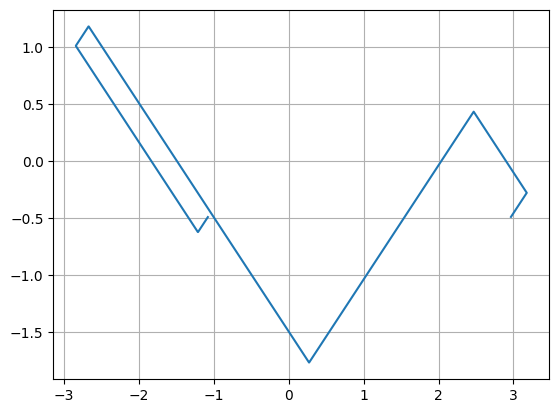

In [227]:
# Look at the position of the particle through time
pos = chain[:, 0, :, :2].squeeze(-2) # squeeze: remove channel dimension
plt.plot(pos[:, 0], pos[:, 1], linestyle='-')
plt.grid(True)
plt.show()

We can now use our GenerationManager object to examine the generated data.

* get animation

'./animation/check.mp4'

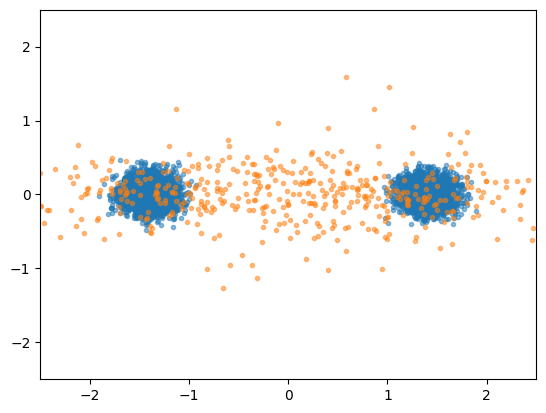

In [215]:
# Use Generation manager object to generate animation from the history of the data
gen_model.history = chain[:, :, :, :2]
gen_model.animation(generated_data_name = 'check')

* Get plot of the generated data.

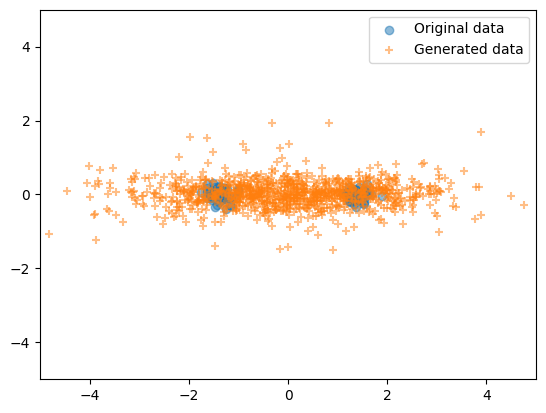

In [228]:
lims = 5
gen_model.samples = chain[-1, :, :, :2].squeeze(-2) # get the last position of every sample, remove channel dimension
gen_model.get_plot(limit_nb_orig_data = 100, # number of original data to plot
                   xlim = (-lims, lims), ylim = (-lims, lims))